### Importing the necessary modules.

1. `Path`module from pathlib provides object oriented interface for working with files and directories.
2. `tqdm` module is used to get a customizable progress bar for training progress observation.
3. `torch.nn` provides classes and function for building and training neural networks.
4. `torch.optim` provides optimization algorithms.
5. `torchvision` provides a bunch of computer vision functionalities including `datasets`, `models` and `transforms`.
6. `toch.nn.functional` contains a large number of neural network functions for training.
7. `torchmetrics` provides a collection of metrics and evaluation functions commonly used in deep learning applications.
8. `pytorch_lightning` is a framework used to build complex DL models by abstracting boilerplate code.
9. `ModelCheckpoint` is used to save the best performing model during training based on given metric.
10. `TensorBoardLogger` allows us to log experiment metrics to TensorBoard.

 

In [22]:
# Import necessary libraries

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

In [23]:
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

Set the random seed for reproducibility.

In [24]:
# Import random module
import random

# Set the random seed
random.seed(42)
torch.manual_seed(42)

The dataset is already available in pytorch and is called **Chest X-ray (Pneumonia)*** dataset.

The dataset is divided into :
1. Train Set
2. Test Set
3. Validation Set

Let's define the path to each of the directory.

In [25]:
# Define path to the data directory
data_dir = Path('/kaggle/input/chest-xray-pneumonia/chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

### Defining the Transformations.

`transforms.Compose()` is used to 

1. `Resize()` is used to resize the size of dataset image as it is extremly larger.
2. `RandomHorizontalFlip()` performs horizontal flipping of an image duiring training.
3. `RandomAffine()` is used to perform a combination of rotations, translations, shears, and zooms. 
4. `RandomResizedCrop()` performs random crop and resize operations on an image during training.
5. `ToTensor()` to convert an image or data from its original format to a tensor.
6. `Normalize()` is used to normalize an image with  specified mean and standard deviation.

In [26]:
# Transformations
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale = (0.35, 1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]),
    
    'val': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]),

    'test': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
}

Applying the Transformations.

In [27]:
# Creating an Empty dictionary

image_datasets = {}

In [28]:
# Applying transformations to test, train and validation data

image_datasets['train'] = datasets.ImageFolder(train_dir,data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(val_dir, data_transforms['val'])
image_datasets['test'] = datasets.ImageFolder(test_dir,data_transforms['test'])

In [29]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5216
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
                RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 16
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0

In [30]:
# Train set
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [31]:
# Test set
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 624
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [32]:
# Validation set
image_datasets['val']

Dataset ImageFolder
    Number of datapoints: 16
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [33]:
train_dataset = image_datasets['train']
val_dataset = image_datasets['val']
test_dataset = image_datasets['test']

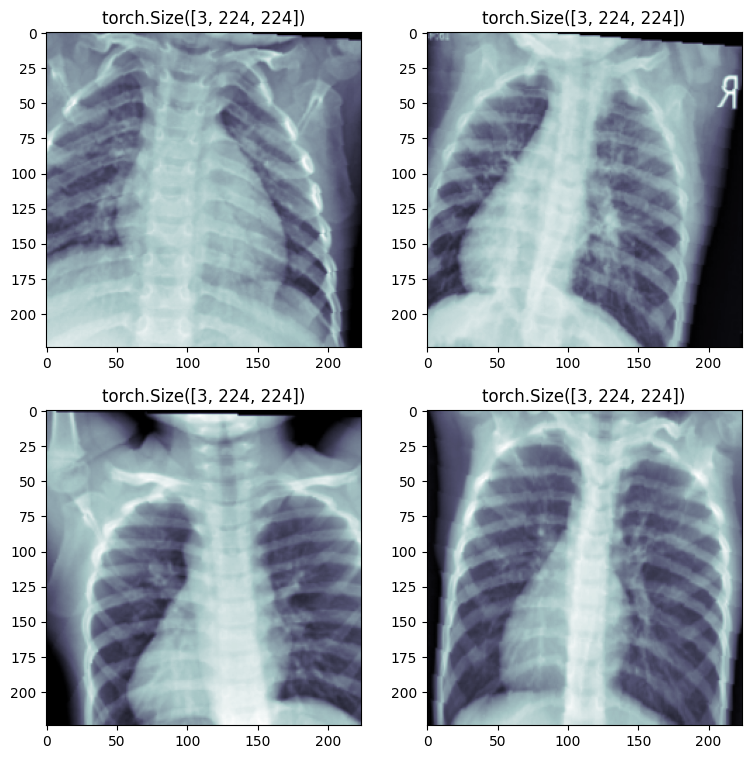

In [34]:
# Randomly observing trauining samples 

fig, axis = plt.subplots(2, 2, figsize = (9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 2000)
        x_ray, label = image_datasets['train'][random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(x_ray.shape)

Create train, validation and test dataloader.

In [35]:
# Setting batchsize and worker number
batch_size = 64
num_workers = 4


# Loading train, test and validation data using DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False) 

In [36]:
# Check the distributions of train_dataset
np.unique(train_dataset.targets, return_counts = True)

(array([0, 1]), array([1341, 3875]))

We can see the class imbalance.

Let's create our Model class. Here, we actually use **Resnet18** model for training our data.

But, in the end layer, we change the number of output neurons from 1000 to a single neuron.

In [37]:
# Observing the Resnet18 architecture

torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here are some of the necessary information regarding the model class we are building:

1. `pl.lightningModule` is similar to `nn.Module`. But because we are using `PyTorch Lightning` as our framework. Hence, `pl.lightningModule`.
2. `torchvision.models.resnet18()` is used to load the resnet model.
3. `self.model.fc = torch.nn.Linear(in_features = 512, out_features = 1, bias = True)` is used to change the number of neurons from 1000 to 1. i.e. manually setting the output layer.
4. `torch.optim.Adam(self.model.parameters(), lr = 1e-4)` is used to set `Adam` as our optimizer function with learning rate of `1e-4`.
5. `torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([0.35]))` implements the binary cross-entropy loss function on our model and the argument `pos_weight` parameter in `BCEWithLogitsLoss` is used to apply a weight to the positive examples in the dataset. In our case particularly, the `pos_weight` parameter is set to `torch.tensor([0.35])`, which means that the positive examples in the dataset will be given 0.35 times the weight than the negative examples. This is done because we have imbalanced dataset and the number of negative sample is about 3 times less than the positive samples.

In [38]:
# Create the model class for training

class PneumoniaModel(pl.LightningModule):
    
    # Constructor
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features = 512, out_features = 1, bias = True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([0.35]))
        
        self.train_acc = torchmetrics.Accuracy(task = "binary")
        self.val_acc = torchmetrics.Accuracy(task = "binary")
        #self.test_acc = torchmetrics.Accuracy()
        
        
        
    # Activation
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))
    
    
    
    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        
        
    def configure_optimizers(self):
        return[self.optimizer]

In [39]:
# Instantiate the model
model = PneumoniaModel()

We create an instance of the `ModelCheckpoint` class with the following parameters:


`monitor`: The metric to monitor during training, which in this case is "`Val ACC`", indicating the validation accuracy.

`save_top_k`: The number of best models to save, which in this case is set to 10. This means that the `ModelCheckpoint` will save the top 10 models based on the validation accuracy.

`mode`: The optimization direction for the monitored metric. In this case, it is set to "`max`", indicating that we want to maximize the validation accuracy.

In [40]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val ACC",
    save_top_k = 10,
    mode = "max"
)

In [41]:
# Configure the trainer
trainer = pl.Trainer(logger = TensorBoardLogger(save_dir = "."), log_every_n_steps = 1, callbacks = checkpoint_callback, max_epochs = 10)

In [42]:
# Train the model
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [43]:
# Check 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [44]:
model.eval()

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [45]:
# Checking the model performance

preds = []
labels = []

# Gradient necessary here
with torch.no_grad():
    for data, label in tqdm(test_dataset):
    
        data = data.to(device).float().unsqueeze(0)
        
        # Calculate probabilities
        pred = torch.sigmoid(model(data)[0].cpu())
        
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


100%|██████████| 624/624 [00:49<00:00, 12.64it/s]


In [46]:
# Accuracy
acc = torchmetrics.Accuracy(task = "binary")(preds, labels)

# Precision
precision = torchmetrics.Precision(task = "binary")(preds, labels)

# Recall
recall = torchmetrics.Recall(task = "binary")(preds, labels)

# Confusion Matrix
cm = torchmetrics.ConfusionMatrix(num_classes=2, task = "binary")(preds, labels)

In [47]:
print(f"Accuracy : {acc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

Accuracy : 0.9310897588729858
Precision : 0.9242053627967834
Recall : 0.9692307710647583
